In [1]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import wget
import zipfile
import numpy as np
import matplotlib as mpl
import shutil
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
spark=SparkSession.builder.appName('COVID').getOrCreate()

23/01/29 21:35:59 WARN Utils: Your hostname, MacBook-Air-Adam.local resolves to a loopback address: 127.0.0.1; using 192.168.198.32 instead (on interface en0)
23/01/29 21:35:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/29 21:36:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Only to download file

# Scrapping CSV file from government site
covid_infections_url = 'https://dane.gov.pl/pl/dataset/2582/resource/41901/table' # url
# Getting chrome webdriver
driver = webdriver.Chrome(executable_path='./chromedriver_mac_arm64/chromedriver')
# Get scraper into url
driver.get(covid_infections_url) 

#driver.find_element(By.XPATH, '//button[text()=" Zamknij "]').click()
driver.find_element(By.CLASS_NAME, 'ng-tns-c170-51').click()
while not os.path.exists('covid_infections.csv'):
    time.sleep(1)


# Cheat dataframe
x =pd.read_csv('covid_infections.csv',sep=';',encoding= 'unicode_escape')
x.head(30)

x.odl_szczep_zar.unique()

In [4]:
df_covid = spark.read.csv('covid_infections.csv',sep =';', header=True, inferSchema=True)

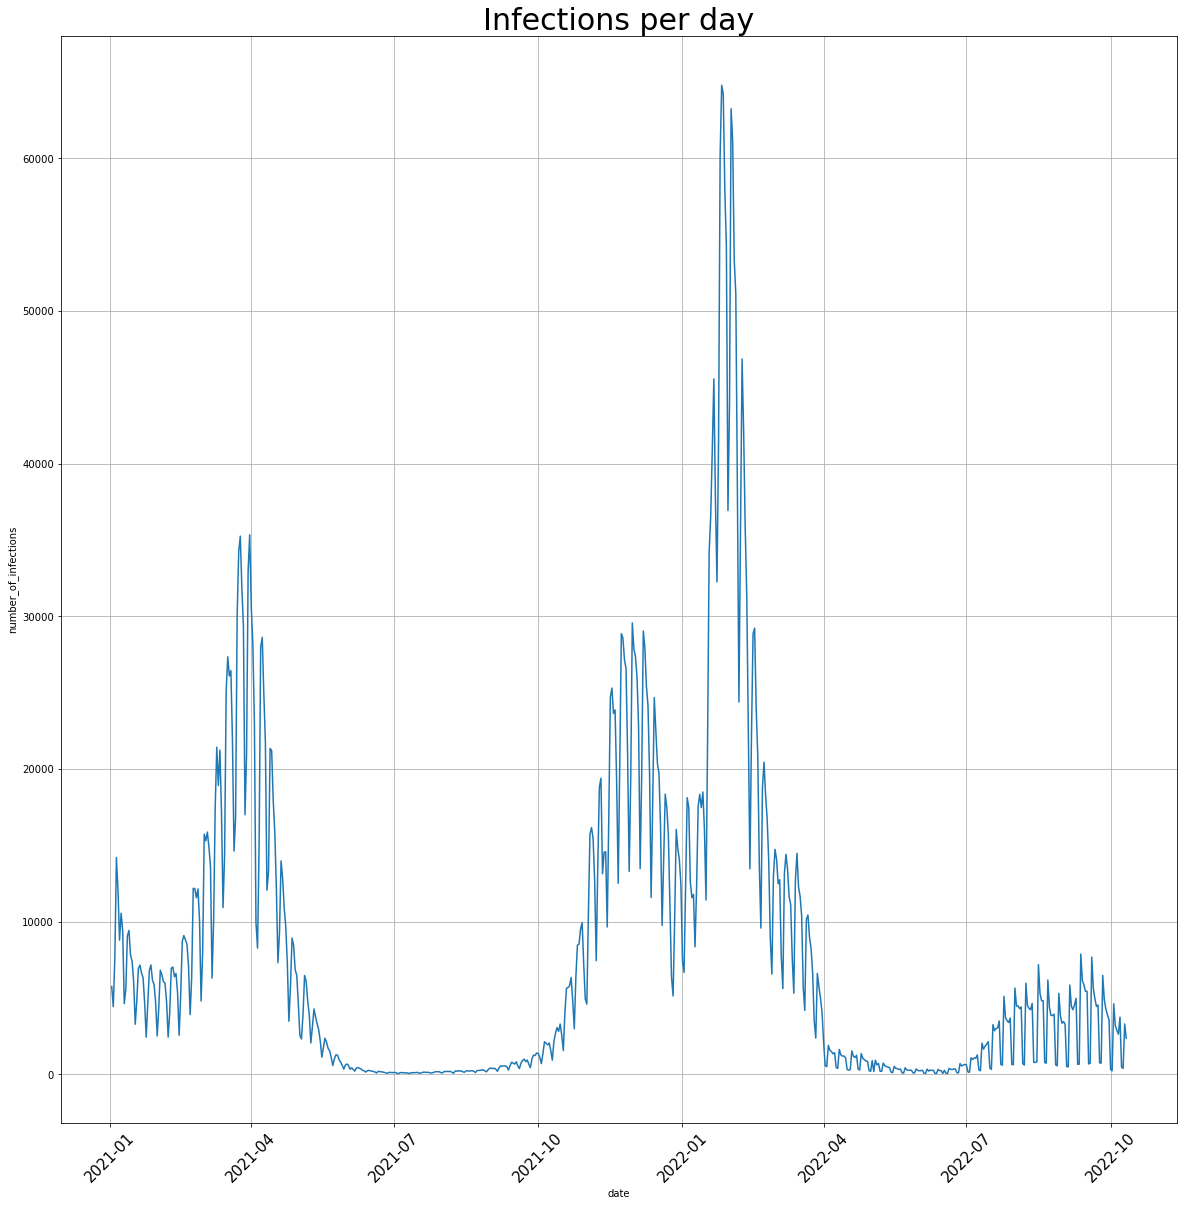

In [837]:
# Creating chart to get raported infections per day
sum_by_day = df_covid.groupBy('data_rap_zakazenia')\
            .sum()\
            .select(
                    'data_rap_zakazenia',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
df_sum_by_day = sum_by_day.toPandas()
df_sum_by_day=df_sum_by_day.rename(columns={
    'data_rap_zakazenia' : 'date',
    'sum(liczba_zaraportowanych_zakazonych)' : 'number_of_infections'
}
                                  )
# Creating lineplot
plt.figure(figsize=(20, 20))
sns.lineplot(data=df_sum_by_day,x='date',y='number_of_infections',
            legend='full')
plt.title("Infections per day", fontsize=30)
plt.xticks(rotation=45, fontsize=15)
plt.grid()

In [53]:
df_sum_by_day.describe().applymap(lambda x: f"{x:0.0f}")

,liczba_zakazonych
count,648
mean,7944
std,11033
min,41
25%,431
50%,3798
75%,11636
max,64784


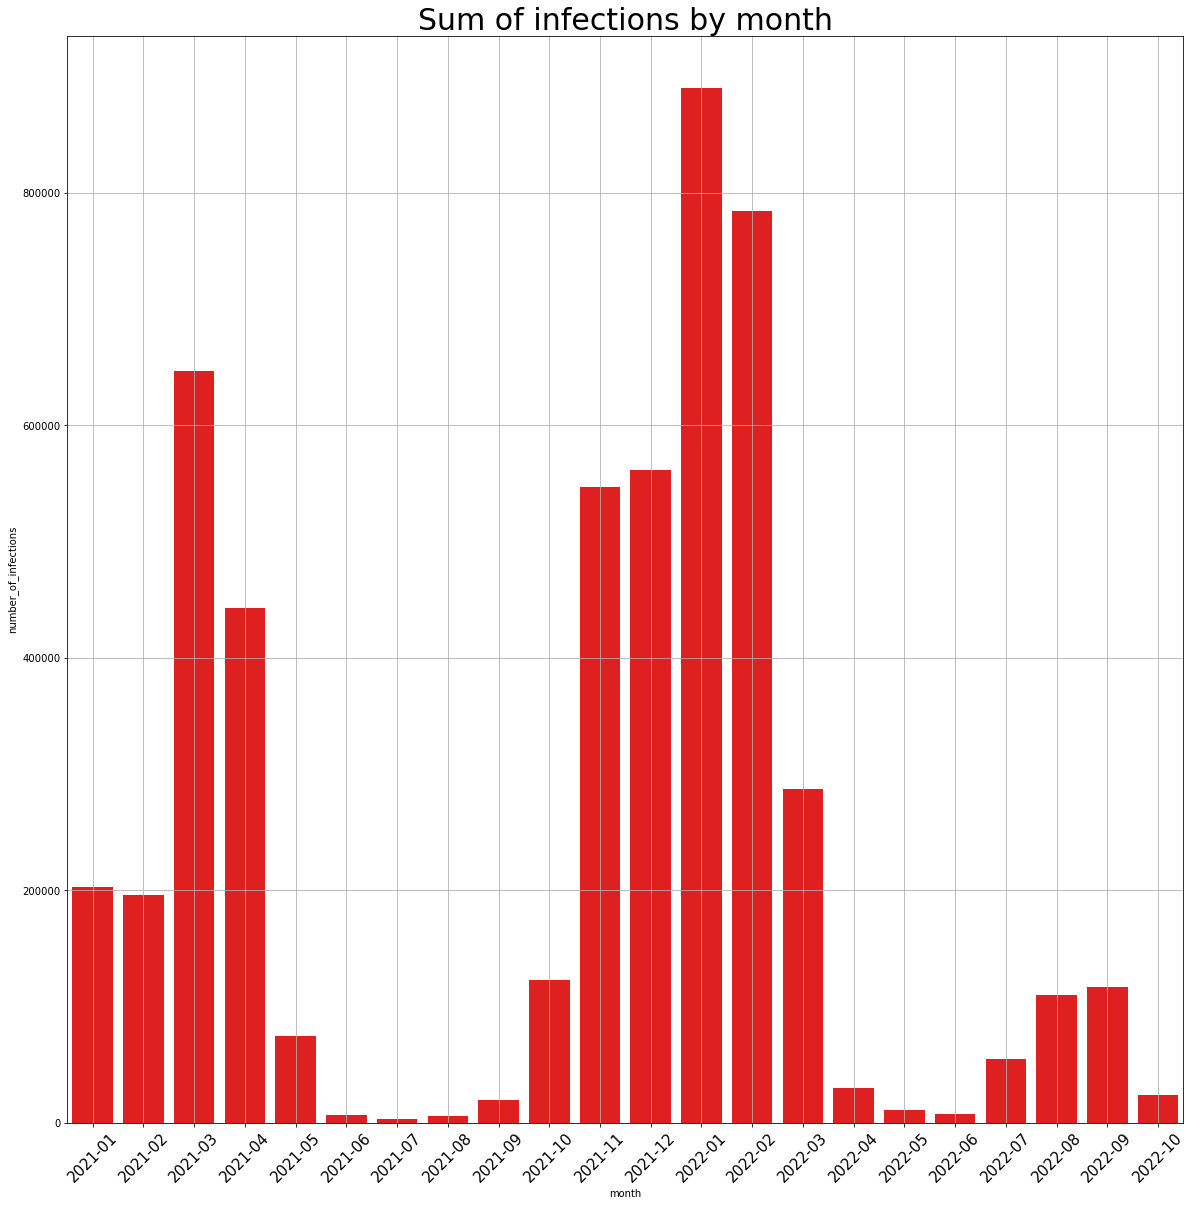

In [876]:
# Plotting graph 'Sum of infections by month'
df_sum_by_month = sum_by_day.toPandas()
df_sum_by_month=df_sum_by_month.rename(columns={
    'data_rap_zakazenia' : 'month',
    'sum(liczba_zaraportowanych_zakazonych)' : 'number_of_infections'
}
                                  )
df_sum_by_month['month'] = df_sum_by_month['month'].apply(
                            lambda x: str(x)[:7])
df_sum_by_month = df_sum_by_month.groupby(['month']).sum()
df_sum_by_month = df_sum_by_month.reset_index()
# Creating barplot
plt.figure(figsize=(20, 20))
sns.barplot(data=df_sum_by_month,x='month',y='number_of_infections',
            orient='v', color='red',
           )
plt.title("Sum of infections by month", fontsize=30)
plt.xticks(rotation=45, fontsize=15)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.grid()

As we can see on description and chart maximum amount of reported infections
happens on winter 2022, also we can see there are 3 significant picks. All 
pick happened cold months, which means that the disease has the most favorable conditions for spreading at low temperatures.

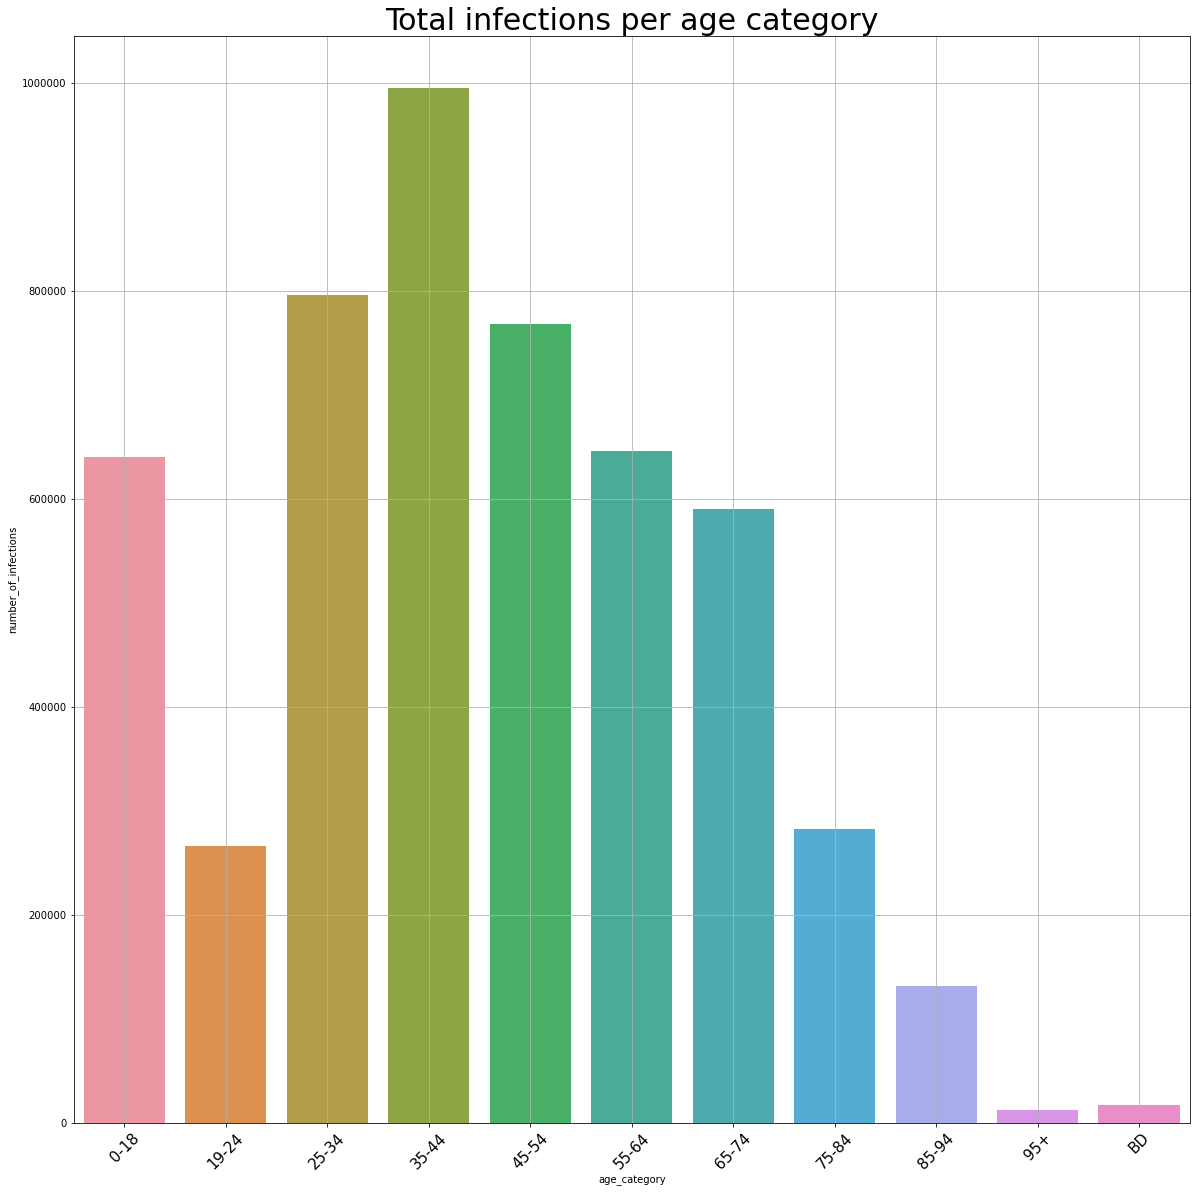

In [835]:
# Creating chart to get total infections per age category
per_age = df_covid.groupBy('kat_wiek')\
            .sum()\
            .select(
                    'kat_wiek',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
df_per_age = per_age.toPandas()
df_per_age=df_per_age.rename(columns={
    'kat_wiek' : 'age_category',
    'sum(liczba_zaraportowanych_zakazonych)' : 'number_of_infections'
}
                                  )
# Creating barplot
plt.figure(figsize=(20, 20))
sns.barplot(data=df_per_age,x='age_category',y='number_of_infections',
            order=[
                '0-18', '19-24', '25-34', '35-44', '45-54', '55-64', 
                '65-74', '75-84', '85-94', '95+', 'BD',
            ],
            orient='v',
           )
plt.title("Total infections per age category", fontsize=30)
plt.xticks(rotation=45, fontsize=15)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.grid()

As we can see the biggest chance to get infected in the range 25-54. In this
range the most exposed age category is 35-44. Despite the appearance of many diseases in old age, the tendency of infections over 55 years of age is decreasing. Additionaly we can see the graph behaves like a normal distribution, excluding the 18-24 age group, which may mean that people at this age are not tested for covid infection.

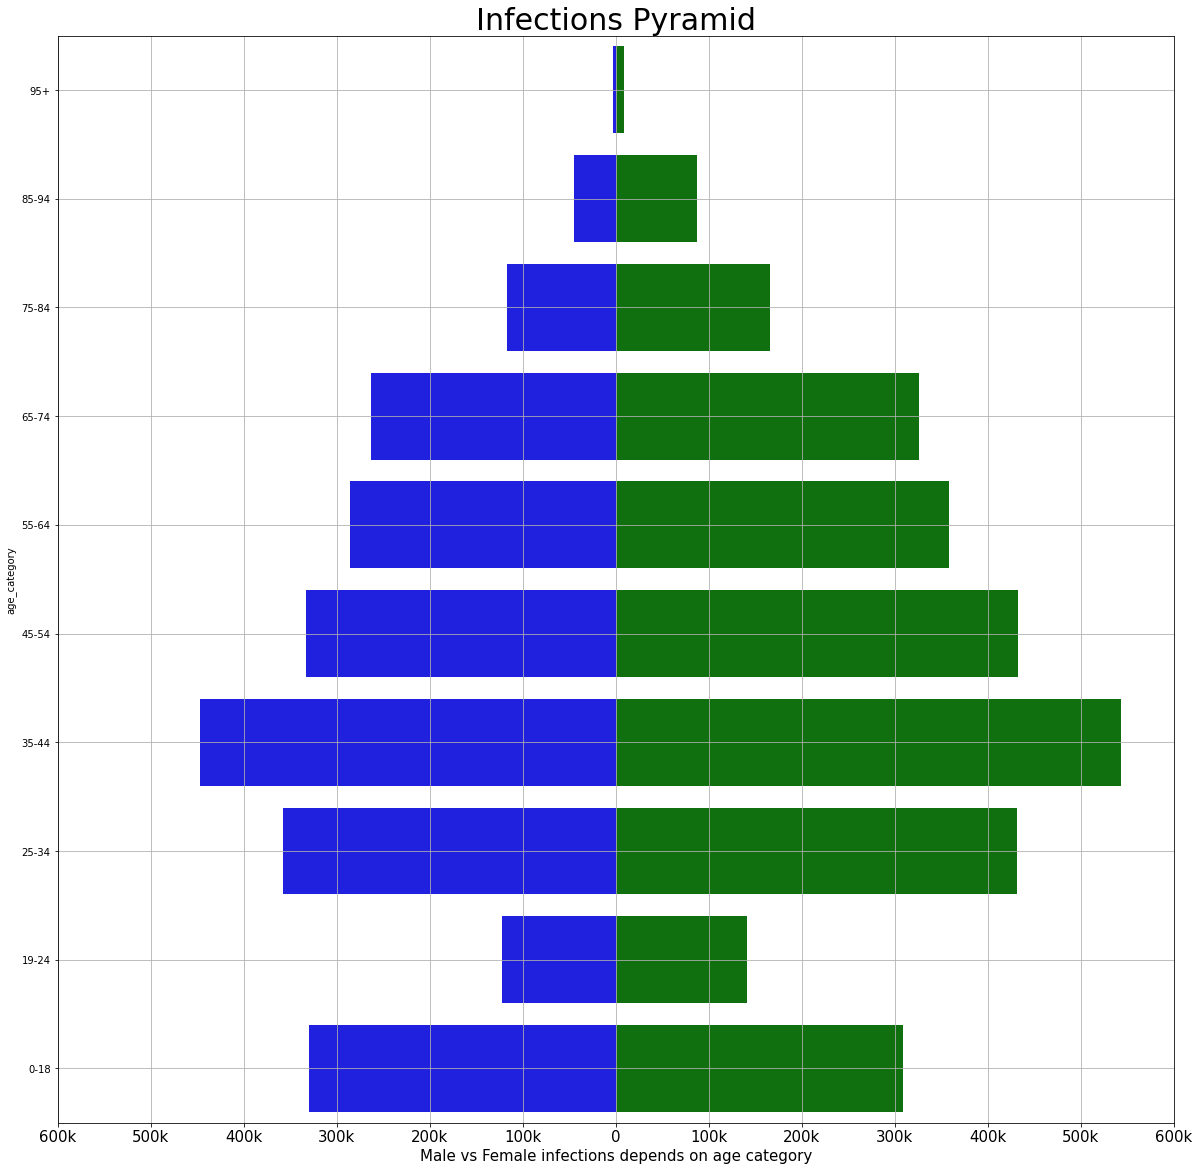

In [877]:
# Creating chart to get raported infections per day
df_pyramid = df_covid.groupBy('plec', 'kat_wiek')\
            .sum()\
            .select(
                    'plec',
                    'kat_wiek',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
df_pyramid = df_pyramid.where(df_pyramid.plec != 'nieznana')\
            .where(df_pyramid.kat_wiek != 'BD')
df_pyramid = df_pyramid.toPandas()
df_pyramid=df_pyramid.rename(columns={
    'plec' : 'sex',
    'kat_wiek' : 'age_category',
    'sum(liczba_zaraportowanych_zakazonych)' : 'number_of_infections'
}
                                  )
# Configure dataframe for pyramid plot
M = df_pyramid[df_pyramid.sex == 'M']
M = M.rename(columns={'number_of_infections' : 'M'})
M = M.drop(columns='sex')
M = M.sort_values(by='age_category')
F = df_pyramid[df_pyramid.sex == 'K']
F = F.rename(columns={'number_of_infections' : 'F'})
F.sex = 'F'
F = F.drop(columns='sex')
F = F.sort_values(by='age_category')
F['M'] = list(M['M'])
df_pyramid = F
df_pyramid['M'] = df_pyramid['M'].apply(lambda x: -x)
# Plotting
order=[
    '0-18', '19-24', '25-34', '35-44', '45-54', '55-64', 
    '65-74', '75-84', '85-94', '95+',
][::-1]
plt.figure(figsize=(20, 20))
ax1 = sns.barplot(x='M', y='age_category', data=df_pyramid, order=order, color='blue')
ax2 = sns.barplot(x='F', y='age_category', data=df_pyramid, order=order, color='green')
plt.title("Infections Pyramid", fontsize=30)
plt.xlabel("Male vs Female infections depends on age category", fontsize=15)
plt.xticks(ticks=[
    -600000, -500000, -400000, -300000, -200000, -100000, 0, 
    100000, 200000, 300000, 400000, 500000, 600000,
],
labels=['600k', '500k', '400k','300k', '200k', '100k', '0', 
        '100k', '200k', '300k', '400k', '500k', '600k'],
        fontsize=15
          )
plt.grid()

In [186]:
print(
    f'''
    Total number of Female infections: {df_pyramid.F.sum()}\n
    Total number of Male infections: {-df_pyramid.M.sum()}
    '''
)


    Total number of Female infections: 2804088

    Total number of Male infections: 2301157
    


In [825]:
# Prepare data to check if infected was vaccinated or not
df_vaccination = df_covid.groupBy('producent')\
            .sum()\
            .select(
                    'producent',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
df_vaccination = df_vaccination.toPandas()
df_vaccination=df_vaccination.rename(columns={
    'producent' : 'producer',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )
not_vaccinated = df_vaccination.iloc[0,1] # first row, second column
vaccinated = df_vaccination.drop(index=[0,2]).sum()

In [826]:
# Lets see prepared data
df_vaccination

,producer,sum_of_infected
0,None,3113884
1,Pfizer,1523487
2,brak danych,1154
3,Johnson&Johnson,168059
4,Moderna,117474
5,Astra Zeneca,223767
6,Novavax,120


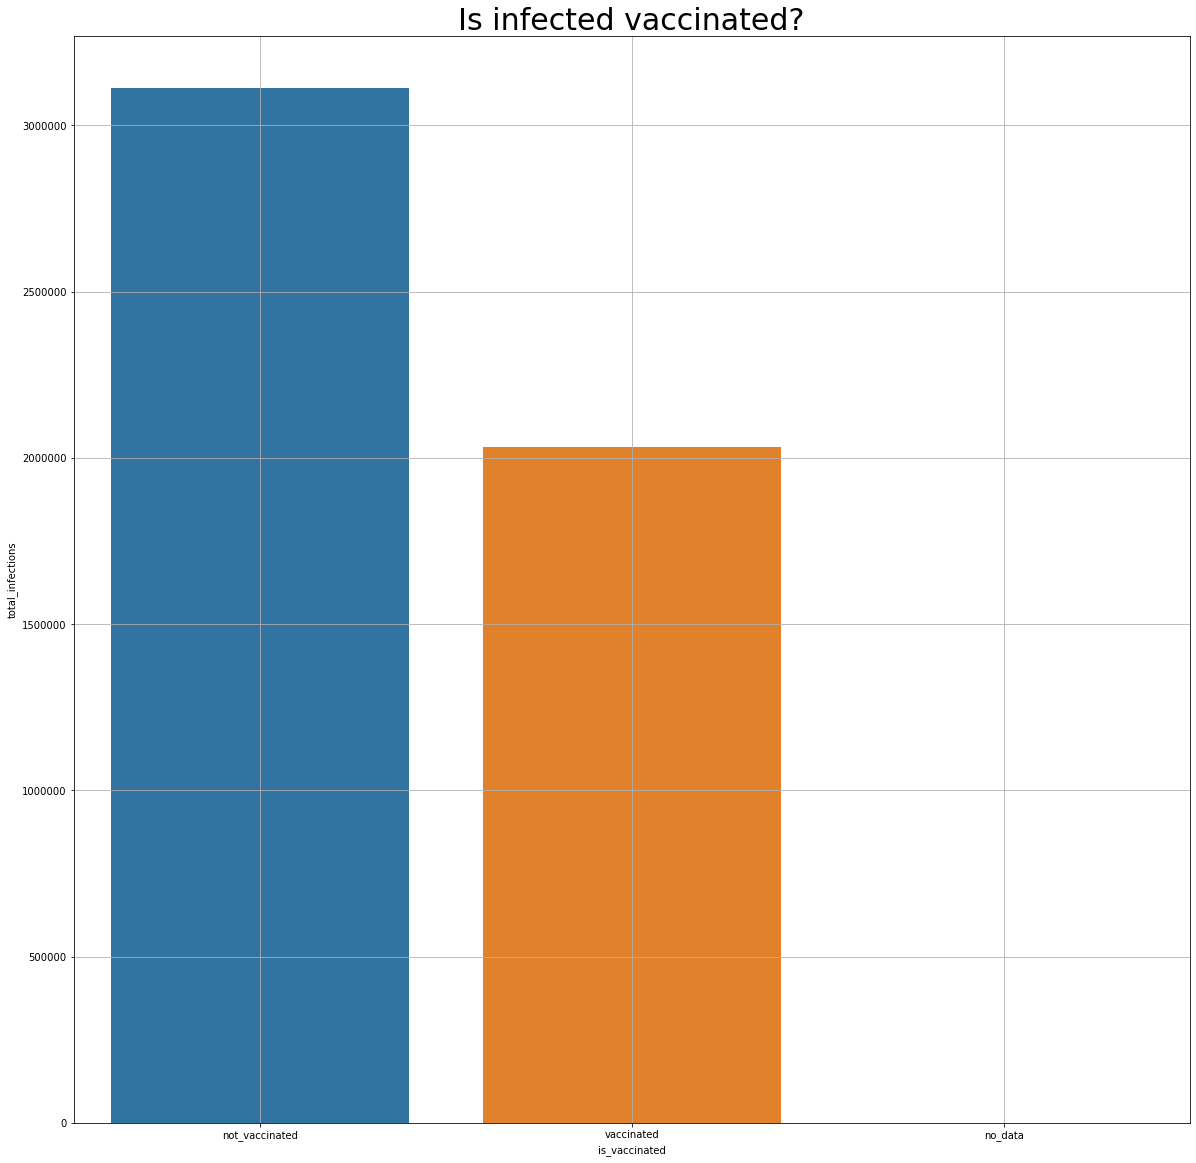

In [827]:
# Creating barplot to check if infected was vaccinated or not
not_vaccinated = df_vaccination.iloc[0,1] # first row, second column
no_data = df_vaccination.iloc[2,1] # third row, second column
vaccinated = df_vaccination.drop(index=[0,2]).sum()['sum_of_infected']
is_vaccinated = pd.DataFrame(
    {
        'is_vaccinated': ['not_vaccinated','vaccinated','no_data'],
        'total_infections': [not_vaccinated, vaccinated, no_data],
    }
)
plt.figure(figsize=(20, 20))
sns.barplot(data=is_vaccinated, x='is_vaccinated',y='total_infections',
            orient='v',
           )
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Is infected vaccinated?",fontsize=30)
plt.grid()

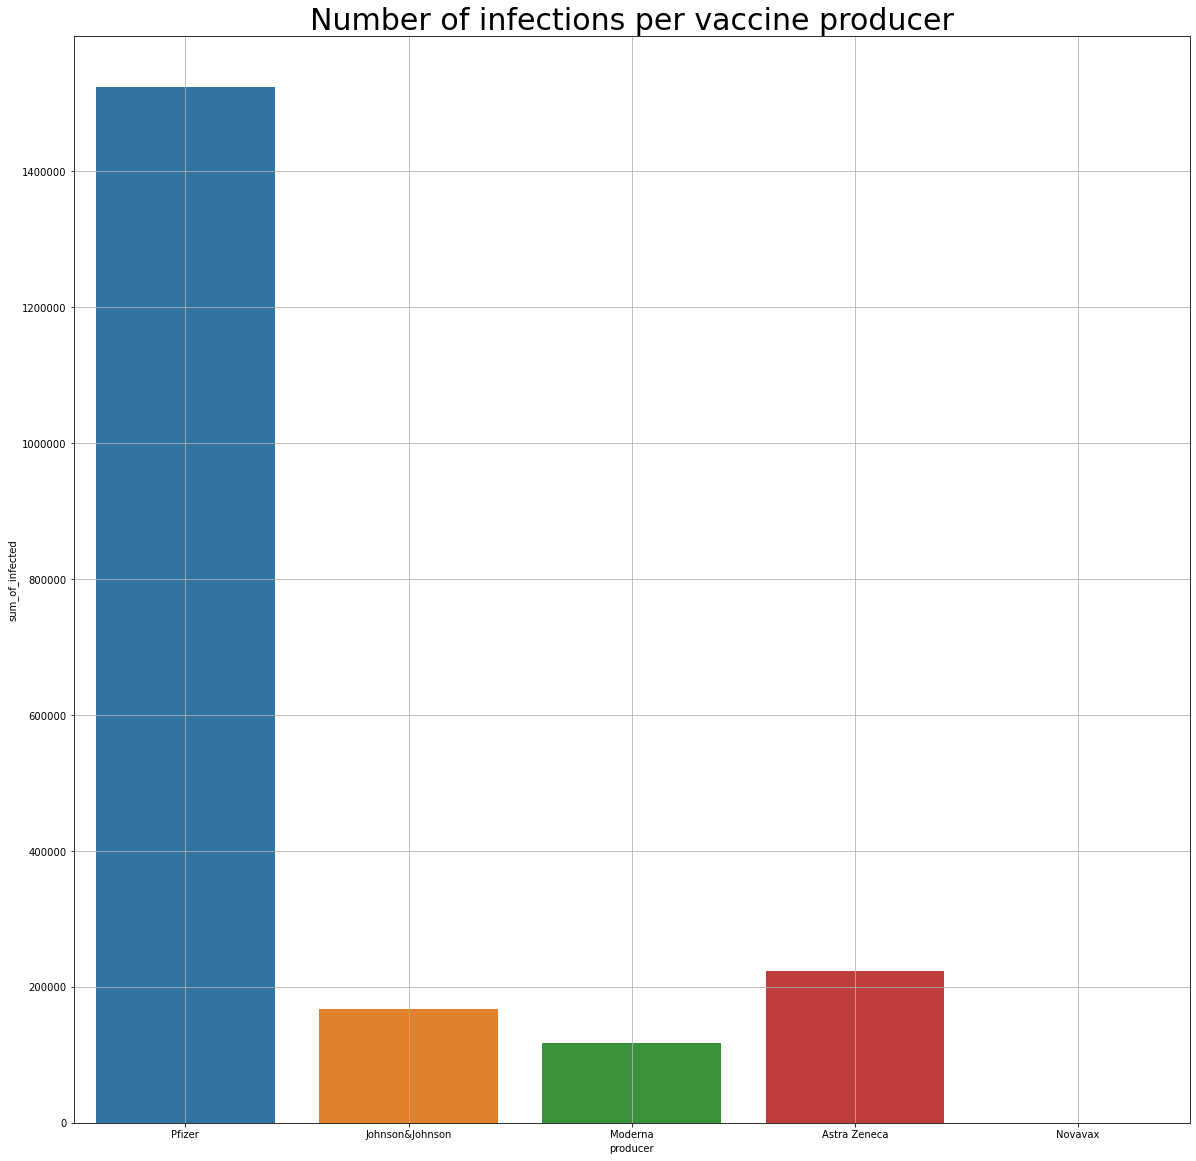

In [828]:
# Checking number of infections per vaccine producer
infections_per_producer = df_vaccination.drop(index=[0,2])
plt.figure(figsize=(20, 20))
sns.barplot(data=infections_per_producer, 
            x='producer',y='sum_of_infected',
            orient='v',
           )
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Number of infections per vaccine producer", fontsize=30)
plt.grid()

In [820]:
# Prepare data to check how many doses of vaccine was taken by infected
df_doses = df_covid.groupBy('dawka_ost')\
            .sum()\
            .select(
                    'dawka_ost',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
df_doses = df_doses.toPandas()
df_doses=df_doses.rename(columns={
    'dawka_ost' : 'num_of_doses',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )
df_doses

,num_of_doses,sum_of_infected
0,jedna_dawka,96716
1,None,3114065
2,pelna_dawka,1343467
3,przypominajaca,569532
4,uzupe�niaj�ca,16237
5,2 przypominajaca,7928


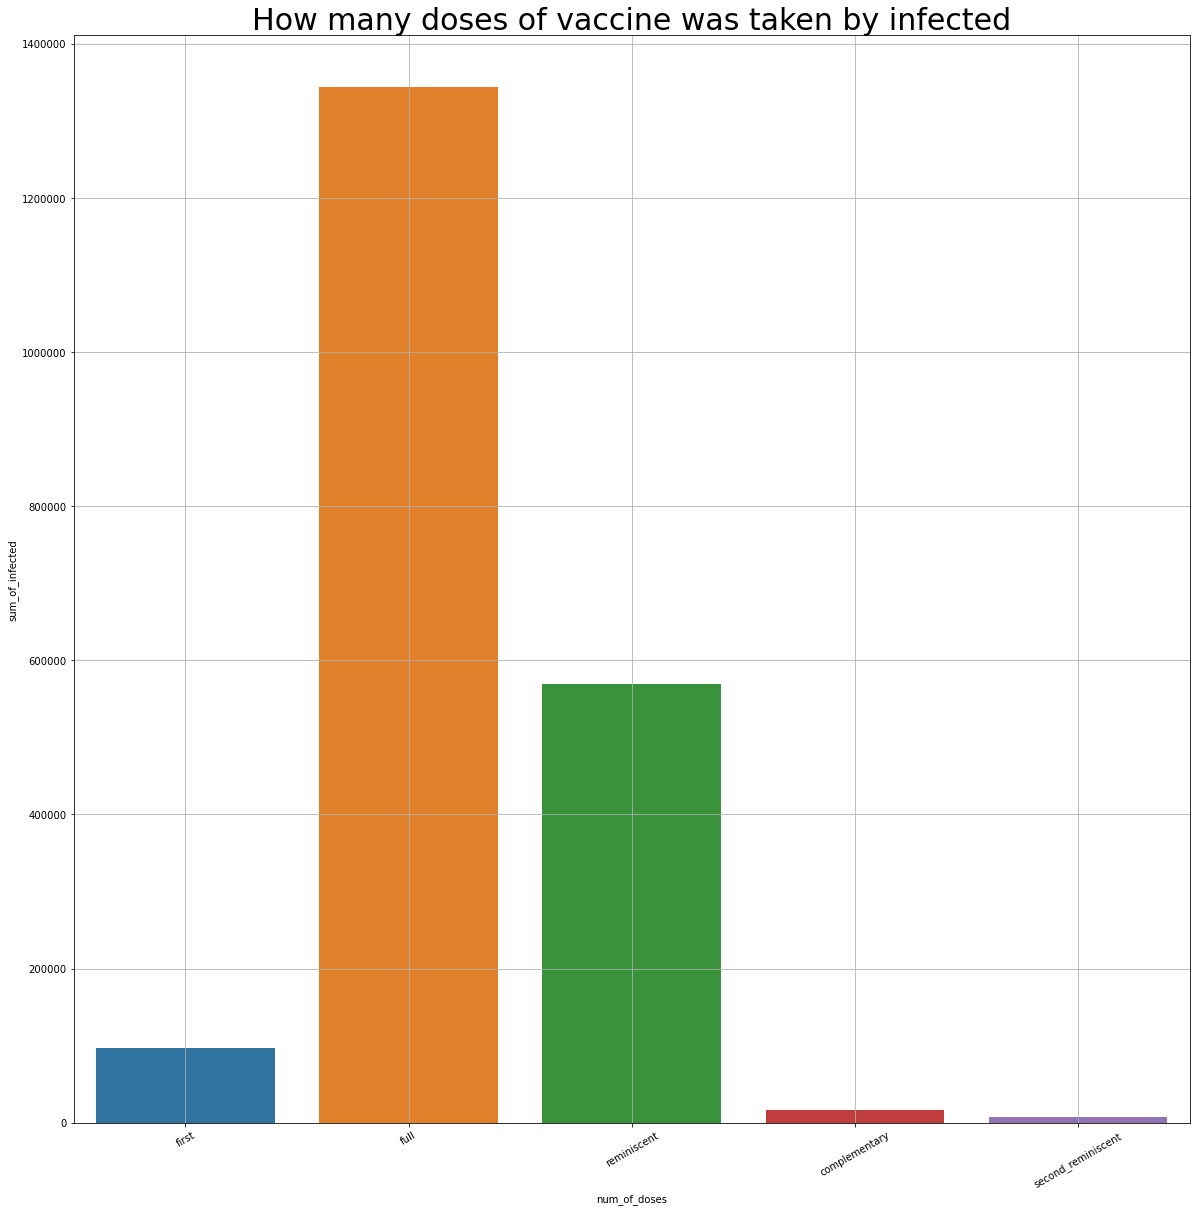

In [821]:
# Prepare data to present with barplot
df_doses = df_doses.drop(index=[1])
translated = {
            'jedna_dawka' : 'first',
            'pelna_dawka' : 'full',
            'przypominajaca' : 'reminiscent',
            'uzupe�niaj�ca' : 'complementary',
            '2 przypominajaca' : 'second_reminiscent',
}
df_doses['num_of_doses'] = df_doses['num_of_doses']\
                            .apply(lambda x: translated[x])
plt.figure(figsize=(20, 20))
sns.barplot(data=df_doses, 
            x='num_of_doses',y='sum_of_infected',
            orient='v',
           )
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.xticks(rotation=30)
plt.title("How many doses of vaccine was taken by infected",fontsize=30)

plt.grid()

In [277]:
# If person was infected, which one time?
num_of_infections_per_person = df_covid.groupBy('numer_zarazenia')\
            .sum()\
            .select(
                    'numer_zarazenia',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
num_of_infections_per_person = num_of_infections_per_person.toPandas()
num_of_infections_per_person=num_of_infections_per_person.rename(columns={
    'numer_zarazenia' : 'which_time',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )

In [278]:
num_of_infections_per_person

,which_time,sum_of_infected
0,1,4864190
1,3,2101
2,4,12
3,2,281642


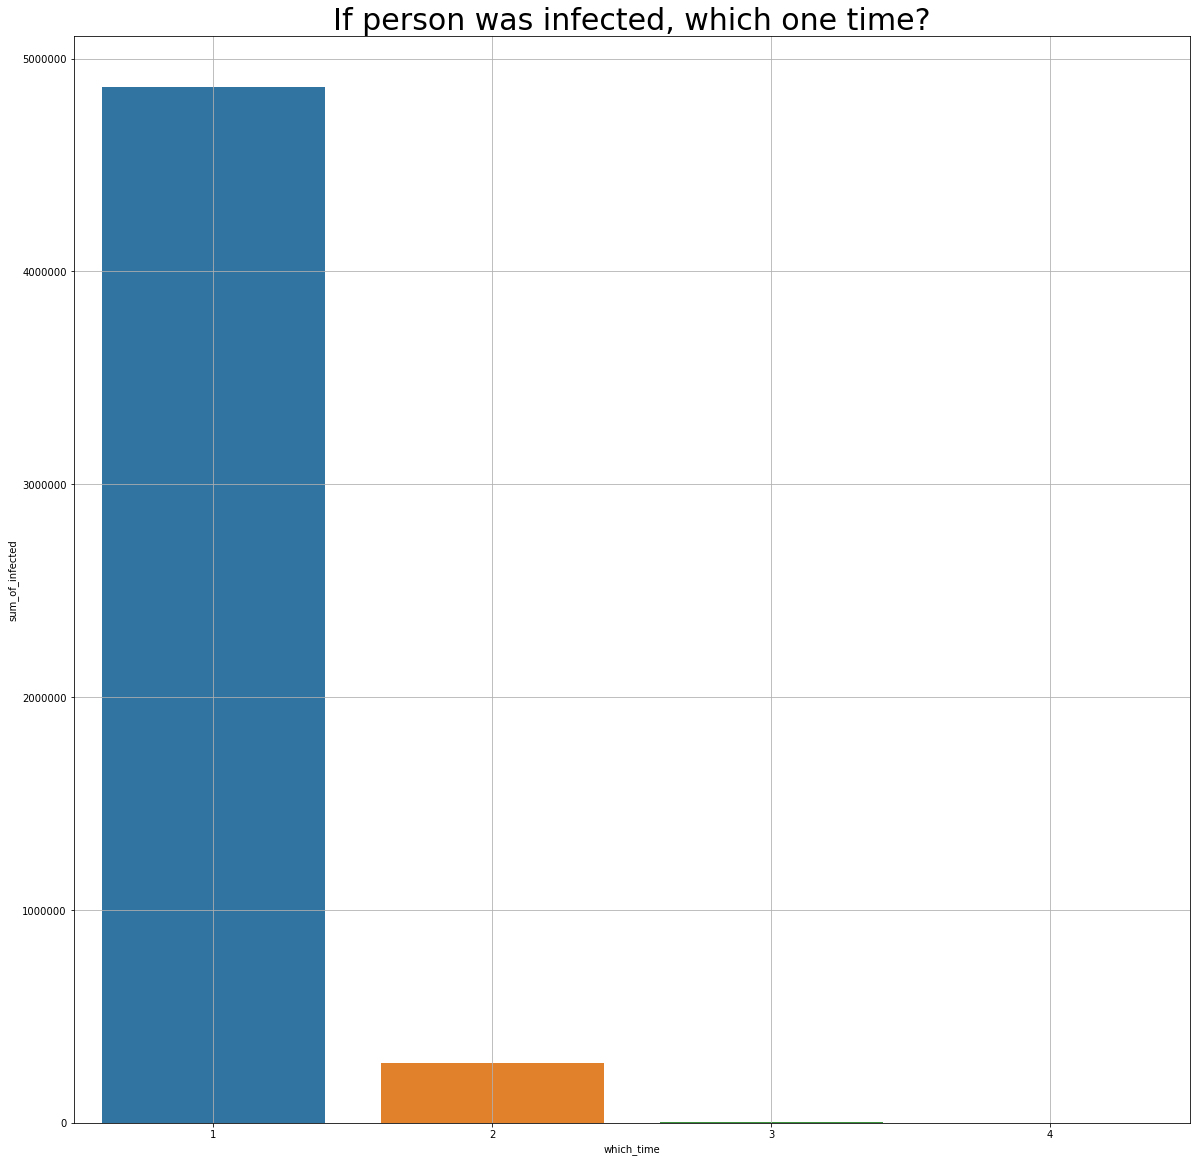

In [822]:
# Creating barplot how many times person was sick
plt.figure(figsize=(20, 20))
sns.barplot(data=num_of_infections_per_person, 
            x='which_time',y='sum_of_infected',
            orient='v',
           )
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("If person was infected, which one time?", fontsize=30)
plt.grid()

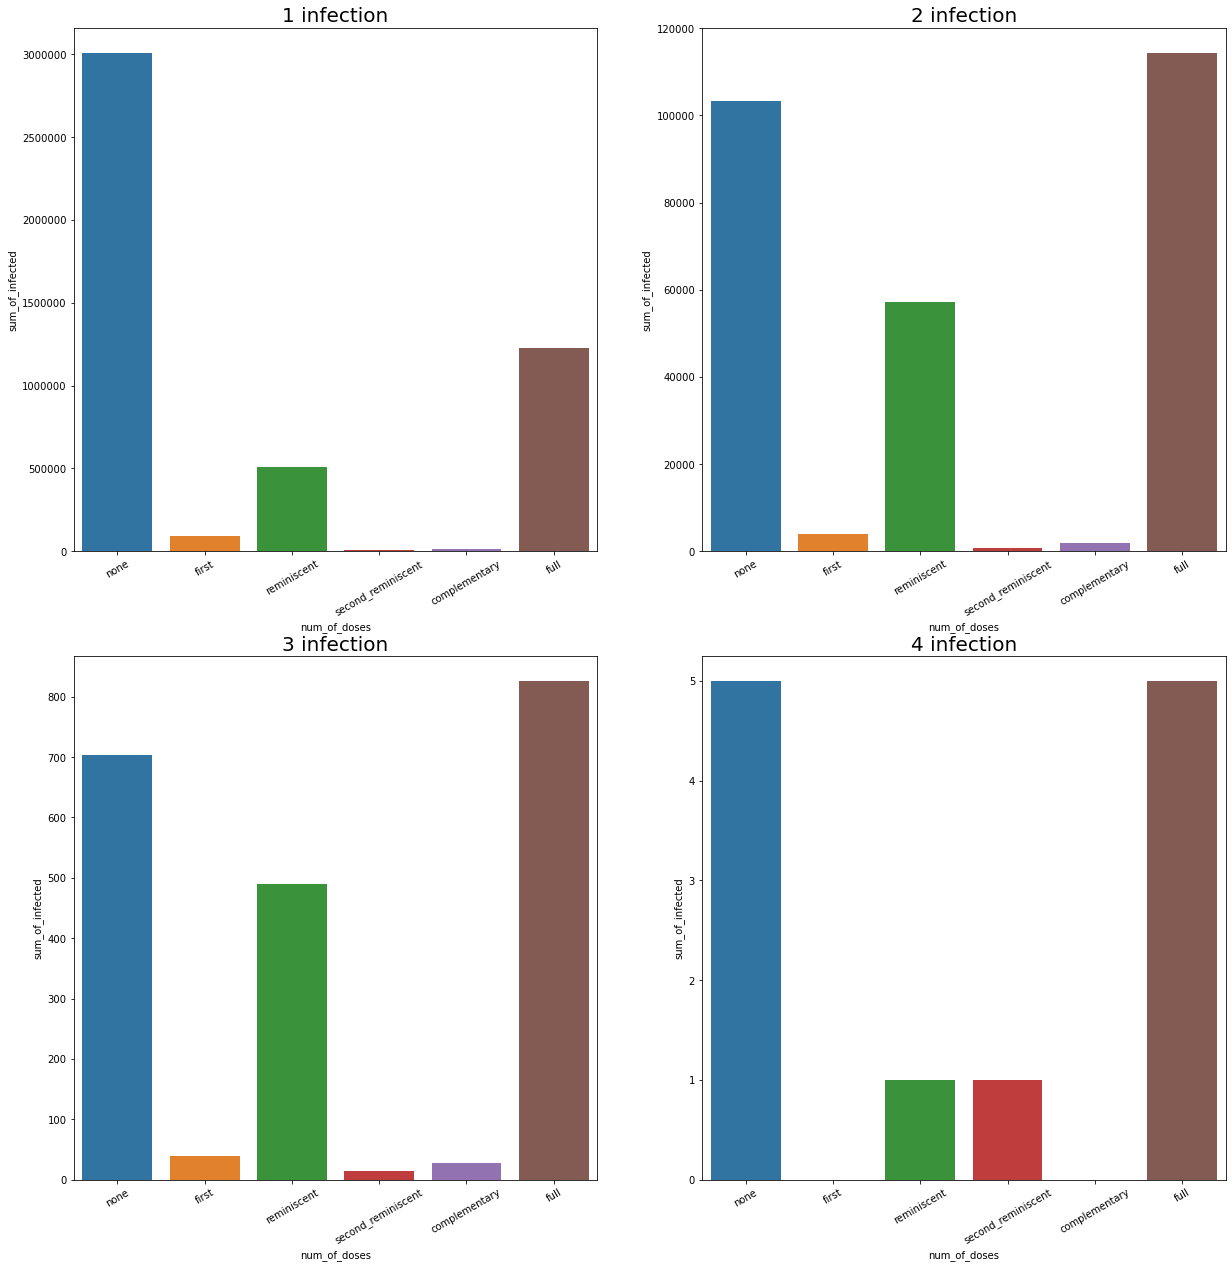

In [410]:
# Now we will check if number of doses avoids getting sick again
is_vac_help = df_covid.groupBy('dawka_ost', 'numer_zarazenia')\
            .sum()\
            .select(
                    'dawka_ost',
                    'numer_zarazenia',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
is_vac_help = is_vac_help.toPandas()
is_vac_help=is_vac_help.rename(columns={
    'numer_zarazenia' : 'which_time',
    'dawka_ost' : 'num_of_doses',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )
translated = {
            'jedna_dawka' : 'first',
            'pelna_dawka' : 'full',
            'przypominajaca' : 'reminiscent',
            'uzupe�niaj�ca' : 'complementary',
            '2 przypominajaca' : 'second_reminiscent',
            None : 'none',
}
is_vac_help['num_of_doses'] = is_vac_help['num_of_doses']\
                            .apply(lambda x: translated[x])
num_of_infections_iter = iter([1,2,3,4])
order=[
    'none', 'first', 'reminiscent', 'second_reminiscent', 
    'complementary', 'full'
]
plt.figure(figsize=(20, 20))
for x in range(2):
    for y in range(2):
        df = is_vac_help
        ax = plt.subplot2grid((2,2), (x,y))
        n = next(num_of_infections_iter)
        df = df[df['which_time'] == n]
        df = df.drop(columns=['which_time'])
        #df = df.groupby(['num_of_doses']).sum()
        sns.barplot(x=df['num_of_doses'],y=df['sum_of_infected'],order=order)
        plt.title(f'{n} infection', fontsize=20)
        plt.xticks(rotation=30)
        plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()

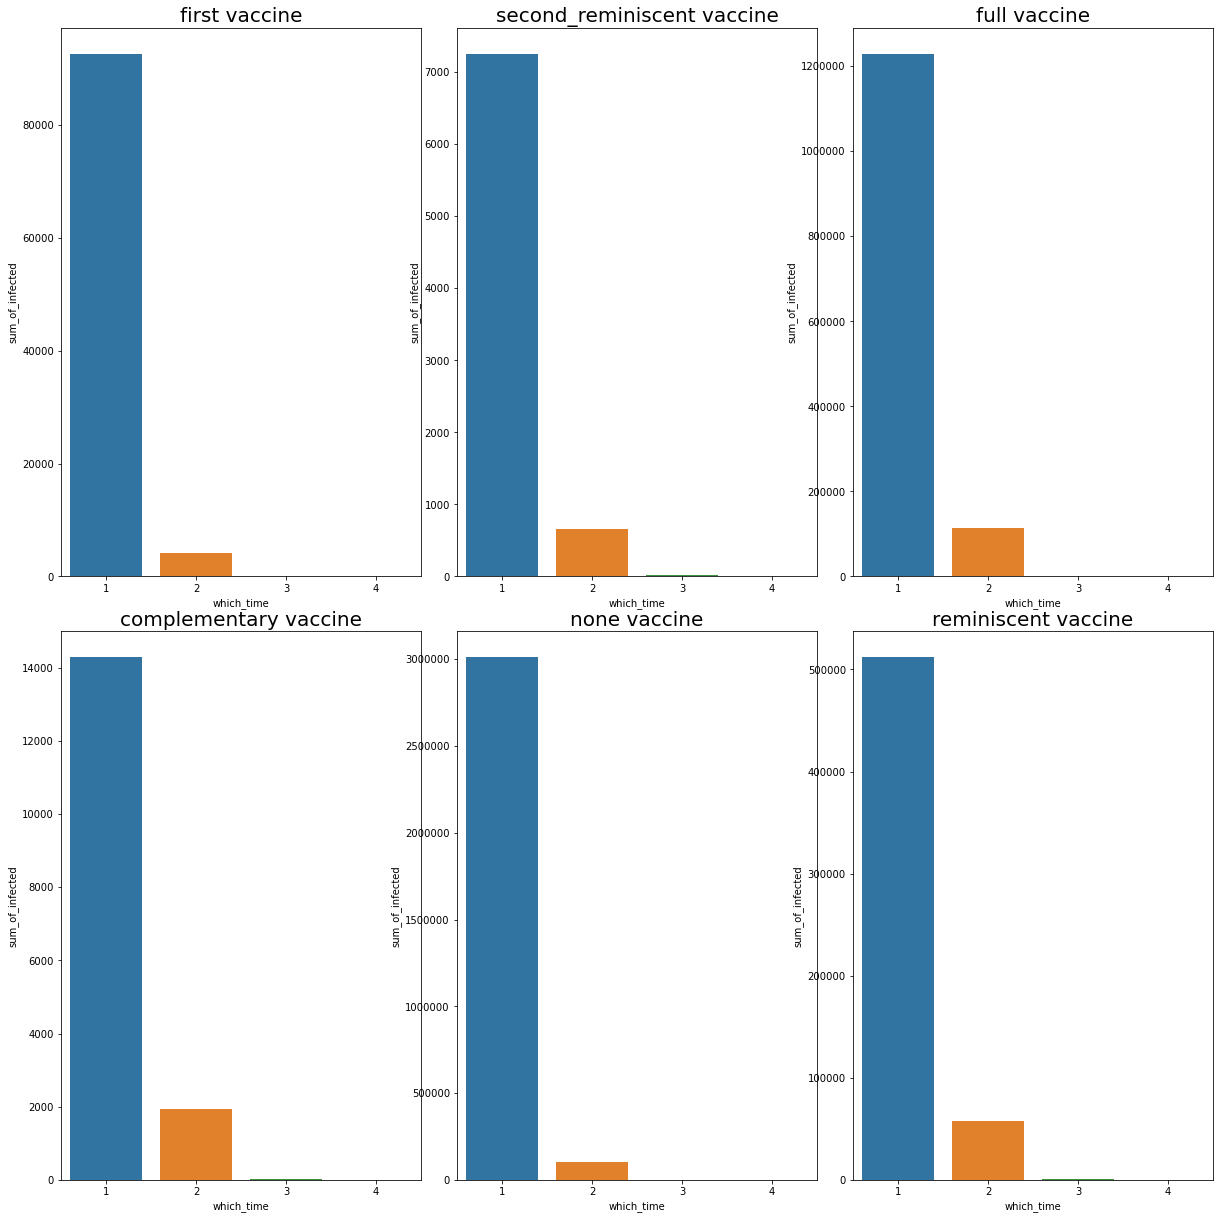

In [409]:
# Now we will check if number of doses avoids getting sick again
is_vac_help = df_covid.groupBy('dawka_ost', 'numer_zarazenia')\
            .sum()\
            .select(
                    'dawka_ost',
                    'numer_zarazenia',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
is_vac_help = is_vac_help.toPandas()
is_vac_help=is_vac_help.rename(columns={
    'numer_zarazenia' : 'which_time',
    'dawka_ost' : 'num_of_doses',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )
translated = {
            'jedna_dawka' : 'first',
            'pelna_dawka' : 'full',
            'przypominajaca' : 'reminiscent',
            'uzupe�niaj�ca' : 'complementary',
            '2 przypominajaca' : 'second_reminiscent',
            None : 'none',
}
is_vac_help['num_of_doses'] = is_vac_help['num_of_doses']\
                            .apply(lambda x: translated[x])
num_of_doses_iter = iter(
    [
        'first', 'second_reminiscent', 
        'full', 'complementary', 'none',
       'reminiscent'
    ]
)
order=[1,2,3,4]
plt.figure(figsize=(20, 20))
for x in range(2):
    for y in range(3):
        df = is_vac_help
        ax = plt.subplot2grid((2,3), (x,y))
        n = next(num_of_doses_iter)
        df = df[df['num_of_doses'] == n]
        df = df.drop(columns=['num_of_doses'])
        sns.barplot(x=df['which_time'],y=df['sum_of_infected'],order=order)
        plt.title(f'{n} vaccine', fontsize=20)
        plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)
plt.show()

In [701]:
# Prepare data to check infections per county
county_infection = df_covid.groupBy('teryt_pow')\
            .sum()\
            .select(
                    'teryt_pow',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
county_infection = county_infection.toPandas()
county_infection=county_infection.rename(columns={
    'teryt_pow' : 'county_id',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )
county_infection['county_id'] = \
county_infection['county_id'].apply(lambda x: str(x))
county_infection = county_infection\
    [county_infection['county_id'] != 'nan']
county_infection['county_id'] = county_infection['county_id']\
    .apply(lambda x: x if len(x)==6 else '0'+x)
county_infection['county_id'] = county_infection['county_id']\
    .apply(lambda x: x[:4])

In [712]:
# Prepare data to check infections per voivodship
voivodship_infection = df_covid.groupBy('teryt_woj')\
            .sum()\
            .select(
                    'teryt_woj',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
voivodship_infection = voivodship_infection.toPandas()
voivodship_infection=voivodship_infection.rename(columns={
    'teryt_woj' : 'voivodship_id',
    'sum(liczba_zaraportowanych_zakazonych)' : 'sum_of_infected'
}
                                  )
voivodship_infection['voivodship_id'] = \
voivodship_infection['voivodship_id'].apply(lambda x: str(x))
voivodship_infection = voivodship_infection\
    [voivodship_infection['voivodship_id'] != 'nan']
voivodship_infection['voivodship_id'] = voivodship_infection['voivodship_id']\
    .apply(lambda x: x if len(x)==4 else '0'+x)
voivodship_infection['voivodship_id'] = voivodship_infection['voivodship_id']\
    .apply(lambda x: x[:2])

In [784]:
# To start with geovisualisation we need to have shape files of units:
# voivodships and counts
# URL to shapefiles
url_voivo = [
        'https://www.gis-support.pl/downloads/2022/wojewodztwa.zip?_ga=2.149327222.1760987319.1672997767-156643027'
        '.1672997767',
        'wojewodztwa'
]
url_county = [
        'https://www.gis-support.pl/downloads/2022/powiaty.zip?_ga=2.149327222.1760987319.1672997767-156643027'
        '.1672997767',
        'powiaty'
]
# Create direction to save and extract zip files
os.makedirs('units')
# Downloadnig zip file:
wget.download(url_voivo[0],'./units/wojewodztwa.zip')
wget.download(url_county[0], './units/powiaty.zip')
# Extracting:
with zipfile.ZipFile(f'./units/wojewodztwa.zip', 'r') as zip_ref:
    zip_ref.extractall('./units')

with zipfile.ZipFile(f'./units/powiaty.zip', 'r') as zip_ref:
    zip_ref.extractall('./units')
# Convert shp file to dataframe
voivodship_map = gpd.read_file('./units/wojewodztwa.shp')
county_map = gpd.read_file('./units/powiaty.shp')
# Remove folder with used files
shutil.rmtree('units')

100% [....................................................] 28231842 / 28231842

In [797]:
# Creating coords column to point numbers of infections on voivodship maps
voivodship_map['coords'] = voivodship_map['geometry'].apply(
    lambda x: x.representative_point().coords[:])
voivodship_map['coords'] = [coords[0] for coords in voivodship_map['coords']]
voivodship_map = voivodship_map\
    .sort_values(by=['JPT_KOD_JE'])
# Rename column name and also sorting values by unit id
voivodship_infection = voivodship_infection\
    .rename(columns={'voivodship_id':'JPT_KOD_JE'})
voivodship_infection = voivodship_infection\
    .sort_values(by=['JPT_KOD_JE'])

voivodship_map['sum_of_infected'] = list(voivodship_infection.sum_of_infected.values)

In [793]:
#county_map = county_map[['coords','JPT_KOD_JE']]
county_map = county_map\
    .sort_values(by=['JPT_KOD_JE'])
# Rename column name and also sorting values by unit id
county_infection = county_infection\
    .rename(columns={'county_id':'JPT_KOD_JE'})
county_infection = county_infection\
    .sort_values(by=['JPT_KOD_JE'])

### Unfortunatley in shp file from gov site 2 countys don't exsists:

In [760]:
cmu = set(county_map.JPT_KOD_JE) # County map unique values of unit id
ciu = set(county_infection.JPT_KOD_JE) # County infections unique values of unit id

list(ciu-cmu)

['1065', '1265']

In [786]:
county_infection = county_infection[
    county_infection['JPT_KOD_JE'] != '1065'
]
county_infection = county_infection[
county_infection['JPT_KOD_JE'] != '1265'
]

In [787]:
county_map['sum_of_infected'] = list(county_infection.sum_of_infected.values)

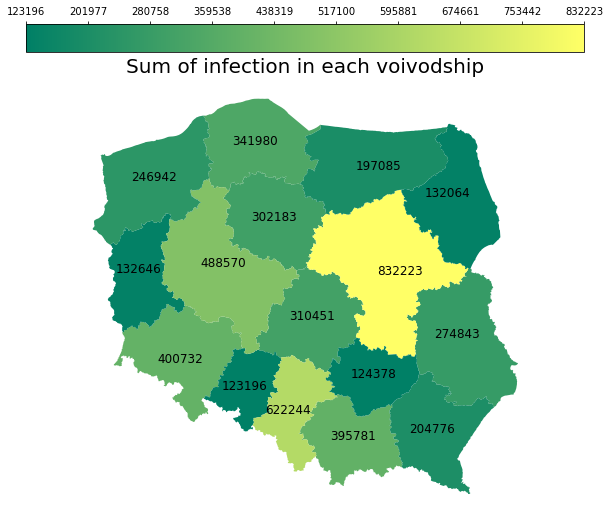

In [800]:
# Plotting a map 'Sum of infections in each voivodship'
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Sum of infection in each voivodship', 
          fontsize=20
         )
#Creating a colormap with colorbar
vmin = voivodship_map['sum_of_infected'].min()
vmax = voivodship_map['sum_of_infected'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in voivodship_map['sum_of_infected']]
fig.colorbar(mappable,ax=ax,location='top', ticks=np.linspace(start=vmin, stop=vmax, num=10))
voivodship_map.plot(ax=ax, color=color, legend=True)
ax.axis('off')
for idx, row in voivodship_map.iterrows():
    plt.annotate(text=row['sum_of_infected'], xy=row['coords'], horizontalalignment='center', color='black',fontsize=12)

(137166.6332206, 896406.6737994001, 101133.5601542, 807108.9379058)

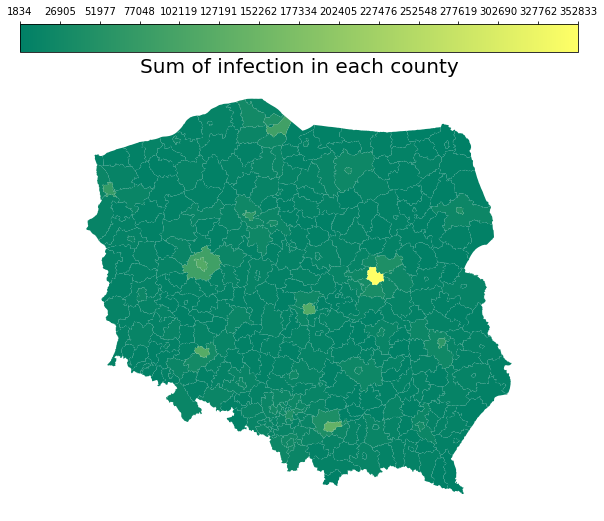

In [795]:
# Plotting a map 'Sum of infections in each county'
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Sum of infection in each county', 
          fontsize=20
         )
#Creating a colormap with colorbar
vmin = county_map['sum_of_infected'].min()
vmax = county_map['sum_of_infected'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in county_map['sum_of_infected']]
fig.colorbar(mappable,ax=ax,location='top', ticks=np.linspace(start=vmin, stop=vmax, num=15))
county_map.plot(ax=ax, color=color, legend=True)
ax.axis('off')

# Waitng for answer from Ministry of Health

In [840]:
# Who know what that data is xd?
who_knows = df_covid.groupBy(
    'dawka_ost', 'odl_szczep_zar'
)\
            .sum()\
            .select(
                    'dawka_ost',
                    'odl_szczep_zar',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )
who_knows = who_knows.toPandas()


In [841]:
who_knows

,dawka_ost,odl_szczep_zar,sum(liczba_zaraportowanych_zakazonych)
0,pelna_dawka,0-90,86575
1,przypominajaca,>360,564
2,uzupe�niaj�ca,180-270,1395
3,przypominajaca,180-270,80660
4,jedna_dawka,None,343
5,None,>360,8
6,None,90-180,56
7,pelna_dawka,90-180,393788
8,None,None,3113885
9,None,180-270,66


## Ideas for aggregates from this data:
* Aggregate of daily reported infections;
* Daily infections per unit id;
* Total infections by age category;
* Total infections by sex and age category;
* Daily infections divided by vaccinated or not

In [22]:
sum_by_day = df_covid.groupBy('data_rap_zakazenia')\
            .sum('liczba_zaraportowanych_zakazonych')\
            .withColumnRenamed('sum(liczba_zaraportowanych_zakazonych)', "sum_of_infections")\
            .withColumnRenamed('data_rap_zakazenia', "day")\
            .select(
                    'day',
                    'sum_of_infections'
                   )

In [19]:
            .select(
                    'data_rap_zakazenia',
                    'sum(liczba_zaraportowanych_zakazonych)'
                   )

SyntaxError: invalid syntax (4274310685.py, line 1)

In [23]:
sum_by_day.show()

+-------------------+-----------------+
|                day|sum_of_infections|
+-------------------+-----------------+
|2022-03-13 00:00:00|             5300|
|2022-07-12 00:00:00|             1645|
|2022-05-22 00:00:00|               65|
|2022-05-03 00:00:00|              173|
|2022-06-19 00:00:00|               47|
|2022-06-14 00:00:00|              234|
|2022-03-28 00:00:00|             6605|
|2022-04-15 00:00:00|             1076|
|2022-07-07 00:00:00|             1045|
|2022-06-12 00:00:00|               45|
|2022-05-06 00:00:00|              704|
|2022-08-22 00:00:00|             6171|
|2022-06-07 00:00:00|              204|
|2022-04-24 00:00:00|              267|
|2022-07-02 00:00:00|              156|
|2022-07-09 00:00:00|              284|
|2022-06-04 00:00:00|               62|
|2022-06-17 00:00:00|              255|
|2022-04-22 00:00:00|             1240|
|2022-08-02 00:00:00|             4472|
+-------------------+-----------------+
only showing top 20 rows



23/01/29 22:24:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 124755 ms exceeds timeout 120000 ms
23/01/29 22:24:58 WARN SparkContext: Killing executors is not supported by current scheduler.
